In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from src.common.analysis_and_plots import Visualize as V
from src.features.build_features import FeatureEngineering as FE
from src.common.globals import G
from src.common.globals import split_train_valid_test, get_naive_forecast, calc_errors, save_errors_to_table
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging
import logging
import os

logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

PROJECT_PATH = G.get_project_root()
DATA_DIR_PROCESSED = os.path.join(PROJECT_PATH, r'data\03_processed\daily_full')

config = {
    'AV': {
        'key': '',
        'ticker': 'MSFT',
        'outputsize': 'full',
        'key_adjusted_close': 'Adj Close',
        'key_volume': 'Volume',
    },
    'data': {
        'test_size': 0.05,
    }, 
    'model': {
        'name': 'LSTM', 
        'window': 20,
        'batch_size' : 30,
        'shuffle_buffer_size' : 1000,
        'epochs' : 100,
    },
}


In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        """Generates dataset windows

        Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method

        Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
        """

        # Generate a TF Dataset from the series values
        dataset = tf.data.Dataset.from_tensor_slices(series)

        # Window the data but only take those with the specified size
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

        # Flatten the windows by putting its elements in a single batch
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

        # Create tuples with features and labels
        dataset = dataset.map(lambda window: (window[:-1], window[-1]))

        # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)

        # Create batches of windows
        dataset = dataset.batch(batch_size).prefetch(1)

        return dataset

In [65]:
df = CSVsLoader(ticker=config['AV']['ticker'], directory=DATA_DIR_PROCESSED)

test_size_int = int(len(df) * config['data']['test_size'])
df_train = df.iloc[:-test_size_int]
df_test = df.iloc[-test_size_int:]

# DeNormalize the training data in the last layer of the model
max_value = df_train['Adj Close'].max()

train_dataset = windowed_dataset(df_train['Adj Close'], 
                                window_size=config['model']['window'], 
                                batch_size=config['model']['batch_size'], 
                                shuffle_buffer=config['model']['shuffle_buffer_size'])


2023-09-18 09:57:53 - src.data.get_data - INFO - Loaded "..\P7-Trading-Bot\data\03_processed\daily_full\MSFT-daily-full.csv". Number data points 5995. From "1999-11-01 00:00:00" to "2023-08-29 00:00:00"


In [ ]:
list(train_dataset.as_numpy_iterator())[0]

In [70]:
# Build the Model
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                                strides=1,
                                activation="relu",
                                padding='causal',
                                input_shape=[config['model']['window'], 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * max_value) # Unnormalize because of tanh activation in LSTM, whicn outputs values [-1, 1]
        ])

# model.summary(print_fn=logger.info)

In [71]:
# Get initial weights
init_weights = model.get_weights()

In [72]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'], callbacks=[lr_schedule])

Epoch 1/100


190/190 [==============================] - 6s 16ms/step - loss: 28.1002 - lr: 1.0000e-08
Epoch 2/100
190/190 [==============================] - 3s 15ms/step - loss: 24.2258 - lr: 1.1220e-08
Epoch 3/100
190/190 [==============================] - 3s 15ms/step - loss: 21.5456 - lr: 1.2589e-08
Epoch 4/100
190/190 [==============================] - 3s 15ms/step - loss: 17.8941 - lr: 1.4125e-08
Epoch 5/100
190/190 [==============================] - 3s 14ms/step - loss: 13.4449 - lr: 1.5849e-08
Epoch 6/100
190/190 [==============================] - 3s 15ms/step - loss: 12.3160 - lr: 1.7783e-08
Epoch 7/100
190/190 [==============================] - 3s 15ms/step - loss: 11.5811 - lr: 1.9953e-08
Epoch 8/100
190/190 [==============================] - 3s 15ms/step - loss: 10.9040 - lr: 2.2387e-08
Epoch 9/100
190/190 [==============================] - 3s 15ms/step - loss: 10.2259 - lr: 2.5119e-08
Epoch 10/100
190/190 [==============================] - 3s 14ms/step - loss: 9.6313 - lr: 2.8184e-08
Ep

(1e-08, 0.001, 0.0, 100.0)

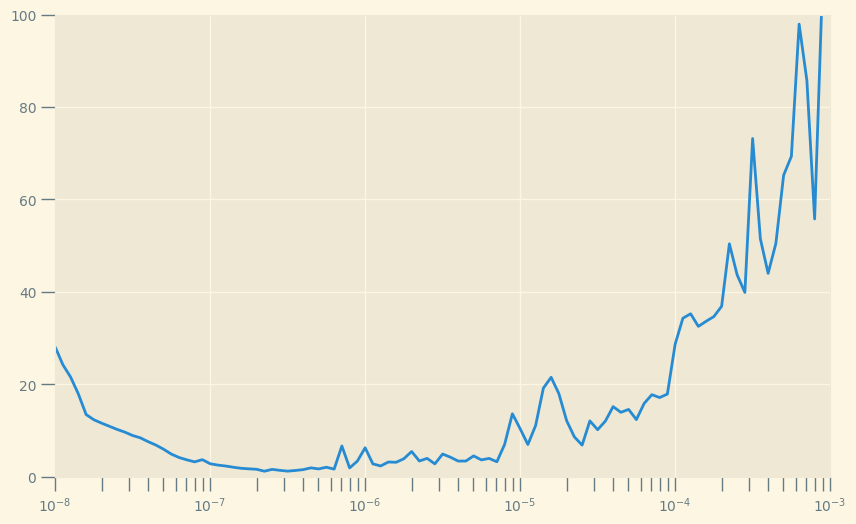

In [73]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

Now Train

In [74]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [75]:
# Set the learning rate
learning_rate = 4e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [76]:
# Train the model
history = model.fit(train_dataset,epochs=100)

Epoch 1/100
190/190 [==============================] - 6s 15ms/step - loss: 12.0033 - mae: 12.4328
Epoch 2/100
190/190 [==============================] - 3s 15ms/step - loss: 5.6329 - mae: 6.0506
Epoch 3/100
190/190 [==============================] - 3s 15ms/step - loss: 3.3861 - mae: 3.8049
Epoch 4/100
190/190 [==============================] - 3s 15ms/step - loss: 2.2681 - mae: 2.6663
Epoch 5/100
190/190 [==============================] - 3s 15ms/step - loss: 1.7200 - mae: 2.0974
Epoch 6/100
190/190 [==============================] - 3s 15ms/step - loss: 1.7722 - mae: 2.1469
Epoch 7/100
190/190 [==============================] - 3s 15ms/step - loss: 1.3209 - mae: 1.6833
Epoch 8/100
190/190 [==============================] - 3s 15ms/step - loss: 2.6143 - mae: 2.9804
Epoch 9/100
190/190 [==============================] - 3s 15ms/step - loss: 1.5281 - mae: 1.9157
Epoch 10/100
190/190 [==============================] - 3s 15ms/step - loss: 1.4305 - mae: 1.8165
Epoch 11/100
190/190 [=====

2023-09-18 10:26:18 - src.common.analysis_and_plots - INFO - Plot "LSTM-MAE and Loss-2023-09-18_10-26-18-2.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-MAE and Loss-2023-09-18_10-26-18-2.png"


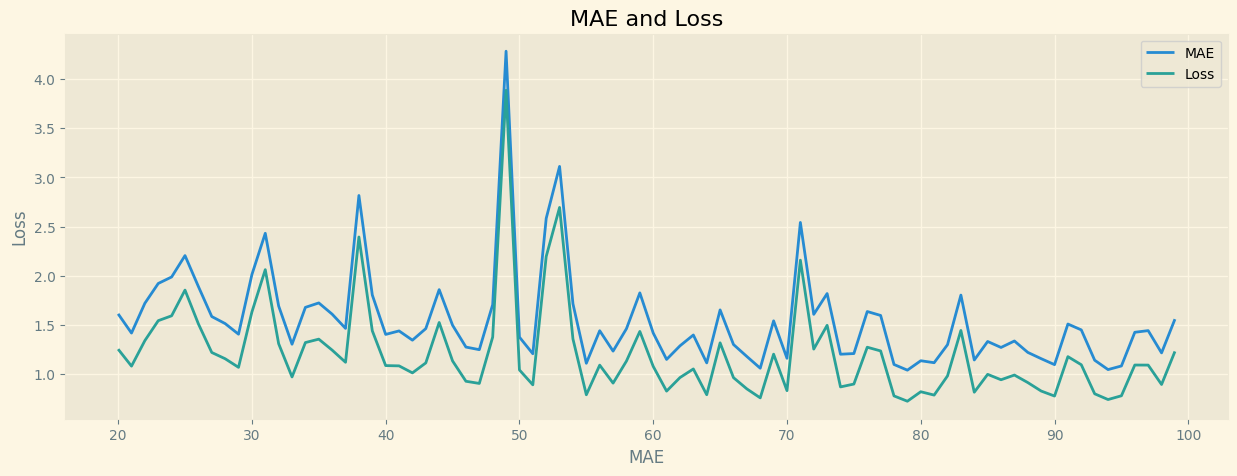

In [84]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Plot MAE and Loss
zoom = int(len(mae) * 0.8)
V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE and Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )


In [85]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
test_size_int = int(len(df) * config['data']['test_size'])
df_train = df.iloc[:-test_size_int]
df_test = df.iloc[-test_size_int:]

10/10 [==============================] - 1s 8ms/step


2023-09-18 10:46:40 - src.common.analysis_and_plots - INFO - Plot "LSTM-None-2023-09-18_10-46-40-6.png" saved to "D:\Study 2018 and later\Mignimind Bootcamp\Code\P7-Trading-Bot\figures\LSTM-None-2023-09-18_10-46-40-6.png"


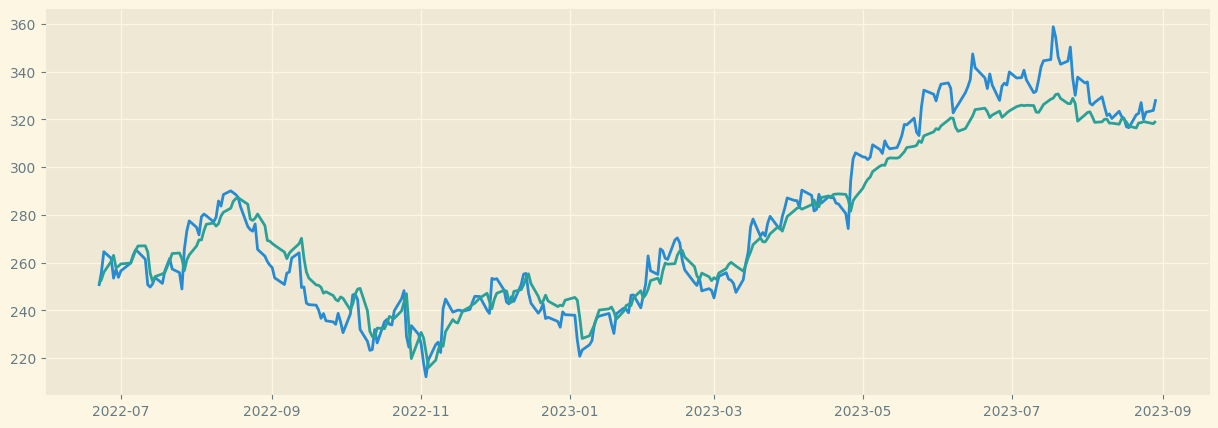

In [93]:
# Reduce the original series
forecast_series = df['Adj Close'].iloc[-test_size_int - config['model']['window']:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, config['model']['window'], config['model']['batch_size'])

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
V.plot_series(x=df_test.index, 
              y=(df_test['Adj Close'], results),
              model_name=config['model']['name'])

In [108]:
# Calculate errors
naive_forecast = get_naive_forecast(df).iloc[-len(df_test['Adj Close']):]
rmse, mae, mape, mase = calc_errors(df_test['Adj Close'], results, naive_forecast)
save_errors_to_table(config['model']['name'], {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-09-18 11:10:43 - src.common.globals - INFO - Test RMSE: $ 9.052
2023-09-18 11:10:43 - src.common.globals - INFO - Test MAE : $ 7.23
2023-09-18 11:10:43 - src.common.globals - INFO - Test MAPE:   0.026
2023-09-18 11:10:43 - src.common.globals - INFO - Test MASE:   1.781
2023-09-18 11:10:43 - src.common.globals - INFO - Errors saved to for LSTM model to "logs/models_table.csv" file.


#### ADAM optimizer - Vasyl try

In [ ]:
# Set the training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # Default is 0.001 = 1e-3
model.compile(loss=tf.keras.losses.Huber(), 
                optimizer=optimizer, 
                metrics=["mae"])    

# Train the model
history = model.fit(train_dataset, epochs=config['model']['epochs'])

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

In [ ]:
# Plot MAE and Loss
zoom = int(len(mae) * 1)
V.plot_series(x=range(config['model']['epochs'])[-zoom:],
                y=(mae[-zoom:],loss[-zoom:]),
                model_name=config['model']['name'],
                title='MAE and Loss',
                xlabel='MAE',
                ylabel='Loss',
                legend=['MAE', 'Loss']
            )

In [14]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
forecast_series = df_test['Adj Close'][-config['model']['window']:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, config['model']['window'], config['model']['batch_size'])

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
V.plot_series(df_test.index, (df_test['Adj Close'], results))

In [ ]:
# Compute the MAE, MSE, RMSE, MAPE, 
from math import sqrt

print(tf.keras.metrics.mean_absolute_error(df_test['Adj Close'], results).numpy())
print(tf.keras.metrics.mean_squared_error(df_test['Adj Close'], results).numpy())
print(sqrt(tf.keras.metrics.mean_squared_error(df_test['Adj Close'], results).numpy()))
print(tf.keras.metrics.mean_absolute_percentage_error(df_test['Adj Close'], results).numpy())
